In [8]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

data_dir = 'Dataset_Disability'
annotation_file = os.path.join(data_dir, '_annotations.csv')

annotations = pd.read_csv(annotation_file, delimiter=';')
print("Columns in annotations DataFrame:", annotations.columns)

def load_data(annotation_df, base_dir):
    images = []
    labels = []
    for _, row in annotation_df.iterrows():
        img_path = os.path.join(base_dir, row['filename'])
        if os.path.exists(img_path):
            img = load_img(img_path)
            img_array = img_to_array(img)
            img_resized = cv2.resize(img_array, (150, 150)) 
            images.append(img_resized)
            labels.append(row['label'])
        else:
            print(f"File {img_path} not found.")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

images, labels = load_data(annotations, data_dir)


Columns in annotations DataFrame: Index(['filename', 'label'], dtype='object')


In [9]:
images = images / 255.0

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels = to_categorical(labels_encoded)

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels_encoded)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.3326 - loss: 2.9914
Epoch 1: val_accuracy improved from -inf to 0.46667, saving model to model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3289 - loss: 3.2229 - val_accuracy: 0.4667 - val_loss: 1.9231
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3973 - loss: 2.0155
Epoch 2: val_accuracy improved from 0.46667 to 0.60000, saving model to model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3839 - loss: 2.0418 - val_accuracy: 0.6000 - val_loss: 1.7626
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.6562 - loss: 1.7520
Epoch 3: val_accuracy did not improve from 0.60000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step - accuracy: 0.6458 - loss: 1.7709 - val_accuracy: 0.4000 - val_loss: 1.7359
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.5781 - loss: 1.6483
Epoch 4: val_accuracy improved from 0.60000 to 0.66667, saving model to model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8667 - loss: 1.1264
Validation Accuracy: 0.8666666746139526


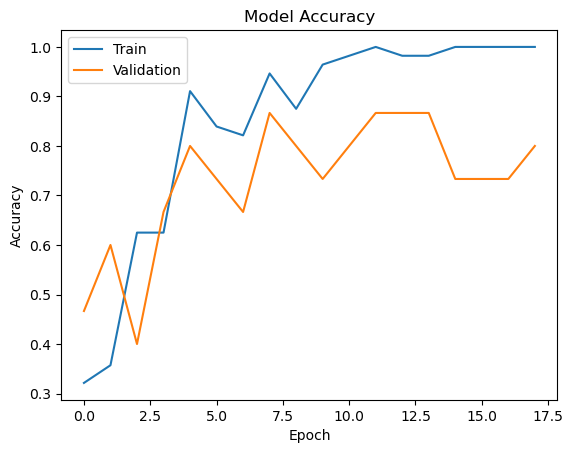

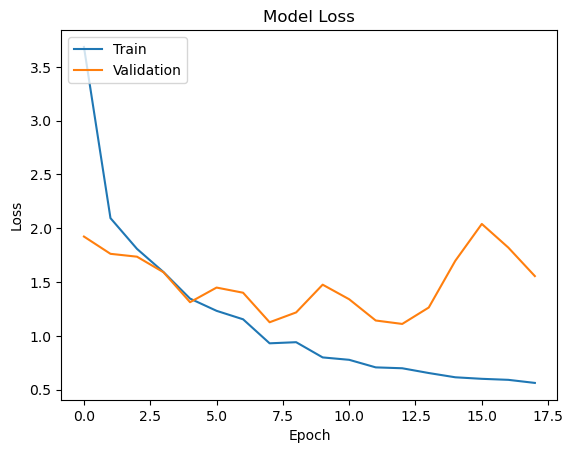

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


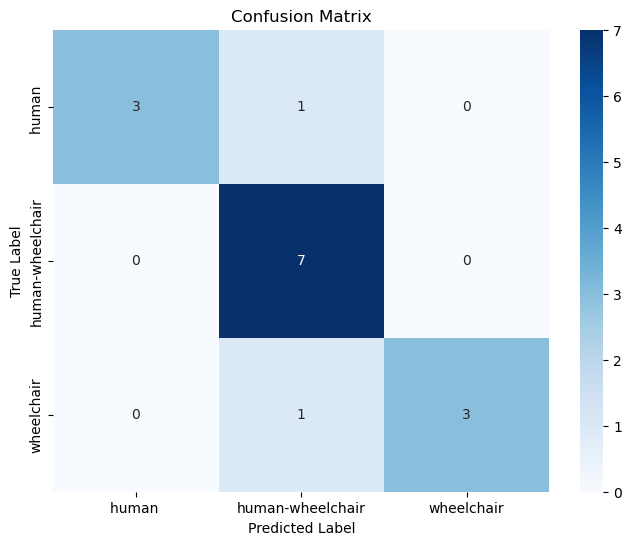

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

best_model = tf.keras.models.load_model('model.keras')

evaluation = best_model.evaluate(X_val, y_val)
print("Validation Accuracy:", evaluation[1])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

predictions = best_model.predict(X_val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)
class_labels = list(label_encoder.classes_)
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [19]:

def preprocess_frame(frame):
    frame = cv2.resize(frame, (150, 150))
    frame = frame.astype('float32') / 255
    frame = np.expand_dims(frame, axis=0)
    return frame

def predict_image(model, img_path, class_labels):
    frame = cv2.imread(img_path)
    if frame is not None:
        preprocessed_frame = preprocess_frame(frame)
        prediction = model.predict(preprocessed_frame, verbose=0)[0]
        label = class_labels[np.argmax(prediction)]
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow("Prediction", frame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("Error: Image not found.")

img_path = 'human.jpeg'
predict_image(best_model, img_path, class_labels)
